In [6]:
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    average_precision_score,
    log_loss,
    zero_one_loss,
)

from sklearn.preprocessing import LabelEncoder

from pathlib import Path

In [2]:
data_path = Path("../data/processed/dataset.csv").resolve()
data = pd.read_csv(data_path)

target = ["health"]

cat_cols = [
    "curb_loc",
    "spc_common",
    "guards",
    "sidewalk",
    "user_type",
    "borough",
]

num_cols = [
    "block_id",
    "tree_dbh",
    "steward",
    "postcode",
    "cncldist",
    "st_senate",
    "nta",
    "ct",
    "x_sp",
    "y_sp",
    "problems",
    "root_problems",
    "trunk_problems",
    "brch_problems",
]

feature_cols = num_cols + cat_cols
target_col = ["health"]

In [4]:
X = data.drop(columns=target)
y = data[target]

target_le = LabelEncoder()
y = target_le.fit_transform(y.squeeze())
y

X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
def get_metrics(y_true, y_pred, pred_proba):
    cm = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    average_precision = average_precision_score(y_true, pred_proba)
    f1 = f1_score(y_true, y_pred, average="weighted")
    l_loss = log_loss(y_true, pred_proba)
    zo_loss = zero_one_loss(y_true, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_le.classes_).plot()
    print("Accuracy:", accuracy)
    print("Balanced accuracy:", balanced_accuracy)
    print("Average precision:", average_precision)
    print("F1 Score:", f1)
    print("log_loss", l_loss)
    print("zo_loss", zo_loss)

/root/anaconda3/envs/analytics/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Balanced accuracy: 0.3333333333333333
Average precision: 0.3333333333333333
F1 Score: 0.7259109024905946
log_loss 6.823953047336506
zo_loss 0.1893246773202213


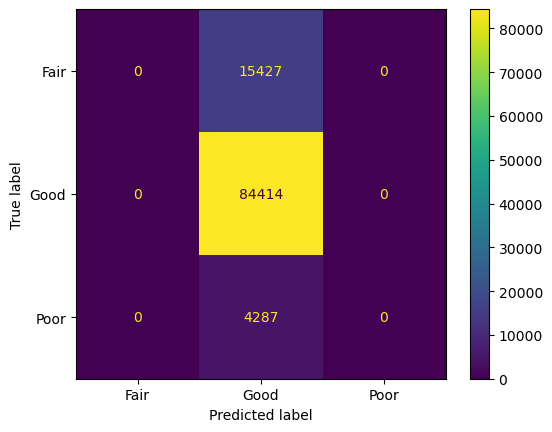

In [7]:
from sklearn.dummy import DummyClassifier

params = {"strategy": "most_frequent"}
dc = DummyClassifier(**params)
dc.fit(X_train, y_train)

y_pred_proba = dc.predict_proba(X_val)
y_pred = dc.predict(X_val)

get_metrics(y_val, y_pred, y_pred_proba)

In [17]:
import copy

def to_category(data):
    data = copy.deepcopy(data)
    for c in data.columns:
        col_type = data[c].dtype
        if (
            col_type == "object"
            or col_type.name == "category"
            or col_type.name == "datetime64[ns]"
            or col_type.name == "string"
            or col_type == "string"
        ):
            data[c] = data[c].astype("category")

    return data

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.75, learning_rate=0.005, max_depth=4, n_estimators=2000, subsample=1;, score=0.812 total time= 2.1min
[CV 2/3] END colsample_bytree=0.75, learning_rate=0.005, max_depth=4, n_estimators=2000, subsample=1;, score=0.812 total time= 2.0min
[CV 3/3] END colsample_bytree=0.75, learning_rate=0.005, max_depth=4, n_estimators=2000, subsample=1;, score=0.812 total time= 1.9min
[CV 1/3] END colsample_bytree=0.75, learning_rate=0.1, max_depth=1, n_estimators=1300, subsample=0.75;, score=0.811 total time=  39.9s
[CV 2/3] END colsample_bytree=0.75, learning_rate=0.1, max_depth=1, n_estimators=1300, subsample=0.75;, score=0.811 total time=  50.3s
[CV 3/3] END colsample_bytree=0.75, learning_rate=0.1, max_depth=1, n_estimators=1300, subsample=0.75;, score=0.811 total time=  48.7s
[CV 1/3] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=1300, subsample=0.75;, score=0.813 total time= 1.3m

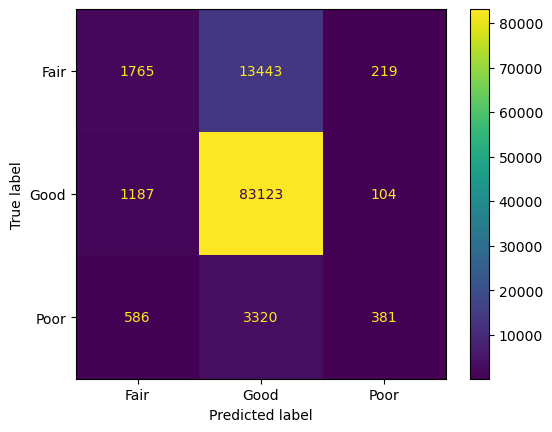

In [25]:
param_grid = {
    "n_estimators": [1300, 1500, 1700, 2000, 2500, 3000],
    "learning_rate": [0.005, 0.01, 0.05, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6],
    "subsample": [0.5, 0.75, 1],
    "colsample_bytree": [0.5, 0.75, 1],
}

model = XGBClassifier(enable_categorical=True, random_state=42, objective="multi:softmax")

rscv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=3,
    scoring="f1_weighted",
    n_jobs=1,
    verbose=5,
    n_iter=10,
)

rscv.fit(to_category(X_train), y_train)

y_pred_proba = rscv.predict_proba(to_category(X_val))
y_pred = rscv.predict(to_category(X_val))

get_metrics(y_val, y_pred, y_pred_proba)